
                          EECS 395, 495: DEEP LEARNING FOUNDATIONS FROM SCRATCH
                                
                                Name- Suman Maroju | Student_ID- 2978953
                          
# PROJECT TITLE: IMAGE CLASSIFICATION: BUILD AN IMAGE CLASSIFIER BASED ON CONVOLUTION NEURAL NETWORKS (USING TENSORFLOW)
                       
The goal of the project is to explore deep learning principles based on CNN for image classification problem.

The project is divided into two parts:

● Part 1: Build and train a CNN model using TensorFlow API for image classification of CIFAR-10 dataset and explore various deep learning principles and optimization techniques for improving the image classification accuracy.

● Part 2: Use a pre trained Google inception v3 model for classifying images and compare the classification results with the model built in Part 1.

Dateset:CIFAR10

API Used:TensorFlow

# Part1

Accuracy of CNN based image classification algorithm depends on its underlying architecture. A CNN architecure is a result of various units such as Number of convolution layers, Filter weights, stride, pooling technique, fully connnected networks.

Following factors were considered while developing the CNN model:

1. Number of layers- Accuracy of CNN based image classifier can increases with the increase in the number of layers but large number of layers may result in overfitting, leading to poor results
2. Depth of the network- Accuracy of image classification increases with the depth of the network but with the increase in depth the computational complexity is also increase leading to greater time consumption during training.
3. Kernel size of layer- Convolution Kernel size  increase the computatioanal complexity of the network.
4. Fragmentation- Using multiple smaller Kernels inplace single big kernel can lead to better accuracy and reduced computational complexity.
5. Max Pooling- Increase in kernel size for max pooling can lead to decrease accuracy due to downsampling of the image.
6. Stride- Low value of stride ensures that the image pixels are not lost during processing.


Based on the initial trial and errors and insights from the previous models proposed by research community the following model was considered for the CNN based on image classification.

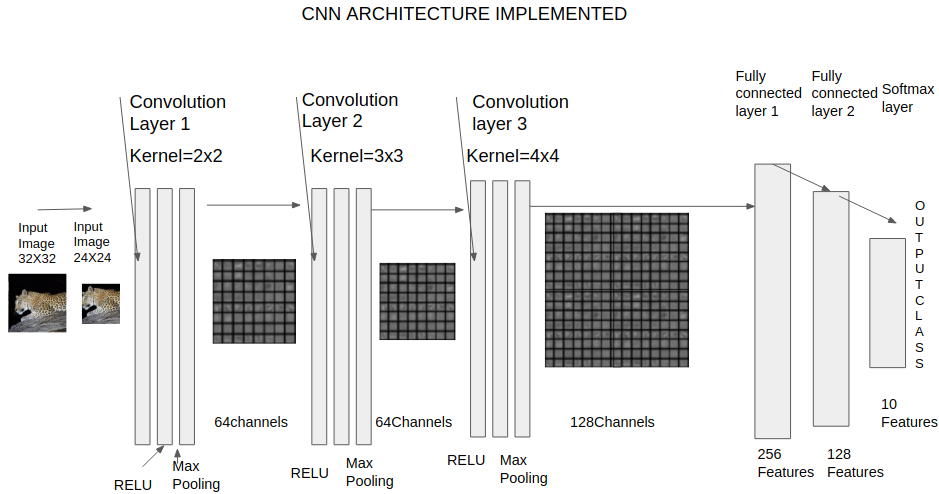

In [1]:
from IPython.display import Image
Image('images/CNN_architecture_implmented.png')

# LOADING CIFAR10 DATA AND PLOTTING SAMPLE IMAGES
Cifar10 data is downloaded and displayed.


/home/ms/anaconda3_2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Size of:
- Training-set:		50000
- Test-set:		10000


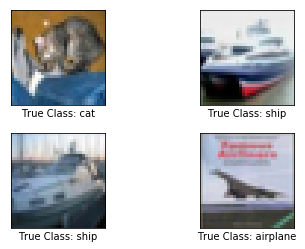

In [2]:
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import prettytensor as pt
import cifar10

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 4
    fig, axes = plt.subplots(2, 2)
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i, :, :, :])
        cls_true_name = class_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "True Class: {0}".format(cls_true_name)
        else:
            cls_pred_name = class_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
 
cifar10.maybe_download_and_extract()
class_names = cifar10.load_class_names()
class_names
images_train, cls_train, labels_train = cifar10.load_training_data()
images_test, cls_test, labels_test = cifar10.load_test_data()
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

from cifar10 import img_size, num_channels, num_classes
img_size_cropped = 24
images = images_test[0:4]
cls_true = cls_test[0:4]
plot_images(images=images, cls_true=cls_true)



# PREPROCESSING AND TENSORFLOW GRAPH VARIABLES DELCARATION:
Following distortions were generated at the training image.
1. Random cropping.
2. Random horizontal flipping.
2. Random Contrast, brightness and saturation altering.

In [3]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

def pre_process_image(image, training):

    if training:

        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_contrast(image, lower=0.2, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.3)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)
    return image

def pre_process(images, training):
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)
    return images
distorted_images = pre_process(images=x, training=True)

Instructions for updating:
Use the `axis` argument instead


# PROPOSED CNN NETWORK IMPLEMENTATION
Network implmentation
1. 3 convolution layers with 64,64 and 128 as number of channels (depth) and incraseing kernel size from 2,3,4 respecitively.
2. 3 max pooling layers-with kernel size of 2, 3, 4 respectively with stride 2.
3. Relu activation
4. fully connected layers with 256 and 128 features
5. Softmax classifers for 10 classes.

In [4]:
def main_network(images, training):
    x_pretty = pt.wrap(images)
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.            conv2d(kernel=2, depth=64,
        name='layer_conv1', batch_normalize=True).max_pool(kernel=3, stride=2).conv2d(kernel=3, depth=128,
        name='layer_conv2', batch_normalize=True).max_pool(kernel=4, stride=2).conv2d(kernel=4, depth=128,                                                                               
        name='layer_conv3').max_pool(kernel=5, stride=2).flatten().fully_connected(size=256,
        name='layer_fc1').fully_connected(size=128, name='layer_fc2').softmax_classifier(num_classes=num_classes, labels=y_true)
     
    return y_pred, loss

def create_network(training):

    with tf.variable_scope('network', reuse=not training):
        images = x
        images = pre_process(images=images, training=training)
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss


global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)
_, loss = create_network(training=True)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)
y_pred, _ = create_network(training=False)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
def get_weights_variable(layer_name):

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

# BATCH NORMALIZATION AND CHECKPOINT CREATION
Batch normazlization is one of the technique used for increasing the CNN classifer accuracy. Batch size 64 is selected.


In [5]:
def get_layer_output(layer_name):
    tensor_name = "network/" + layer_name + "/Relu:0"
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)
    return tensor


output_conv1 = get_layer_output(layer_name='layer_conv1')
output_conv2 = get_layer_output(layer_name='layer_conv2')
session = tf.Session()
save_dir = 'checkpoints/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_path = os.path.join(save_dir, 'cifar10_cnn')

try:
    print("Trying to restore last checkpoint ...")

    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    saver.restore(session, save_path=last_chk_path)

    print("Restored checkpoint from:", last_chk_path)
except:

    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())


train_batch_size = 64


def random_batch():
    num_images = len(images_train)

    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

def optimize(num_iterations):
    start_time = time.time()

    for i in range(num_iterations):

        x_batch, y_true_batch = random_batch()
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}


        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))
        if (i_global % 1000 == 0) or (i == num_iterations - 1):

            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))




Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints/cifar10_cnn-30350
Restored checkpoint from: checkpoints/cifar10_cnn-30350


In [6]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    plot_images(images=images[0:4],
                cls_true=cls_true[0:4],
                cls_pred=cls_pred[0:4])
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    i = 0

    while i < num_images:
        j = min(i + batch_size, num_images)
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j
    correct = (cls_true == cls_pred)

    return correct, cls_pred
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)


def classification_accuracy(correct):
    return correct.mean(), correct.sum()


def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    correct, cls_pred = predict_cls_test()
    acc, num_correct = classification_accuracy(correct)
    num_images = len(correct)
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]


# img, cls = get_test_image(10)

#### RUNNNING THE ITERATIONS & CALCULATING ACCURACY:
After running about 30000 iterations 74% accuracy is achieved on test dataset.

Global Step:  30400, Training Batch Accuracy:  79.7%
Global Step:  30450, Training Batch Accuracy:  78.1%
Saved checkpoint.
Time usage: 0:00:31
Accuracy on Test-Set: 75.0% (7505 / 10000)
[ 0.     0.     0.     0.077  0.     0.916  0.003  0.004  0.     0.   ]


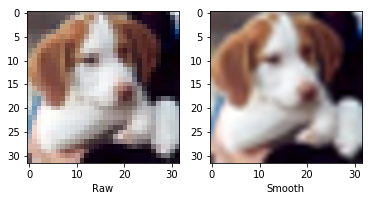

'dog'

In [7]:
if True:
 optimize(num_iterations=100)
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=True)

def plot_image(image):
    fig, axes = plt.subplots(1, 2)
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    plt.show()

img, cls = get_test_image(16)
label_pred, cls_pred = session.run([y_pred, y_pred_cls],
                                   feed_dict={x: [img]})
np.set_printoptions(precision=3, suppress=True)
print(label_pred[0])
plot_image(img)
class_names[3]
class_names[5]

# PART 2
# IMAGE CLASSIFICATION USING PRETRAINED INCEPTION MODEL
Incpetion v3 uses various techniques for improved accuracy in Image classification task. Factorization is a very important trick in Inception-v3, it factorizes big kernels into small kernels, {one 7x7= two 5x5 with strides 2 = three 3x3 with stride 1). Other techniques used in developing inception model are as follows:
1. Deeper and Wider, larger datasets canbe fit well than others, informations each layer learned are so rich that information in high level layer are more abstract and discriminate, and this is very import for image classification.
2. Batch Normalization, very powerful trick for training networks, it can decrease internel covariate shift, also gradient vanish. This can make transfromation from data to label more stable.
3. Factorization, factorization makes the number of parameters less and speed up the training process, also avoids overfits.
4. Redual Connection, which we can train a 100+ layers depth networks(also 1000+ layers) in a easy way. Deeper networks is good for feature extraction.

Data has apparently already been downloaded and unpacked.


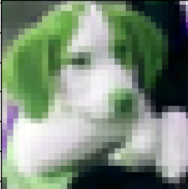

10.00% : Blenheim spaniel
 3.75% : Eskimo dog
 3.29% : giant panda
 3.21% : Shih-Tzu
 3.07% : malamute
 2.89% : Madagascar cat
 2.80% : colobus
 2.62% : Saint Bernard
 1.43% : hair spray
 1.28% : corn


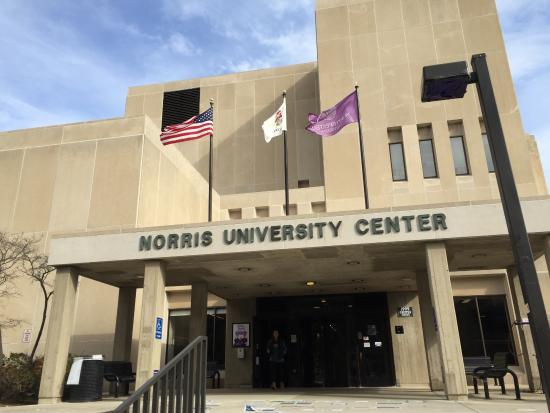

86.17% : cinema
 1.46% : planetarium
 1.19% : restaurant
 1.06% : bakery
 0.59% : library
 0.37% : flagpole
 0.14% : bookshop
 0.10% : prison
 0.07% : rocking chair
 0.07% : grocery store


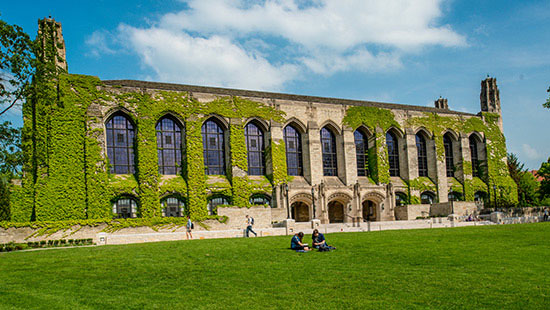

55.19% : viaduct
 5.38% : monastery
 2.08% : vault
 1.76% : church
 1.18% : mosque
 0.97% : palace
 0.81% : castle
 0.79% : triumphal arch
 0.70% : dome
 0.26% : lawn mower


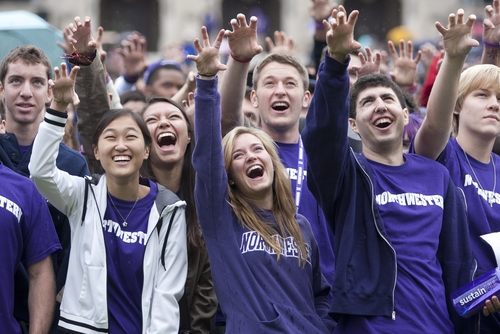

53.09% : basketball
11.88% : volleyball
 5.16% : soccer ball
 4.73% : ballplayer
 3.03% : torch
 2.45% : maillot
 2.15% : rugby ball
 0.91% : football helmet
 0.67% : baseball
 0.61% : jersey


In [8]:
from IPython.display import Image, display
Image('images/07_inception_flowchart.png')
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import inception

inception.maybe_download()
model = inception.Inception()

def classify(image_path):
    display(Image(image_path))
    pred = model.classify(image_path=image_path)
    model.print_scores(pred=pred, k=10, only_first_name=True)    
    
classify(image_path="images/dogpet.png")
classify(image_path="images/norris.jpg")
classify(image_path="images/Building.jpg")
classify(image_path="images/NU_student.jpg")




#### SUMMARY AND CONCLUSION

In this project, a 3 layer CNN is built  that can classify CIFAR10 image dataset with about 74% accuracy. Developing CNN models for image classification requires a combination of trial and error methods, theory and experience based on previous developed models. AlexNet  (2012),ZF Net (2013),VGG Net (2014), GoogLeNet (2015),Microsoft ResNet (2015) are some of the recent works that optimize various parameters of CNN for improving accuracy of the network.


